In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install pytorch-lifestream
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 132.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.2 MB/s eta 0:00:0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=53324466b3d3b83e245bc0b5db0028afc57dc94312eaf25be1a1f528cbb957c1
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [8]:
spark_conf = SparkConf()
spark_conf.setMaster("local[8]").setAppName("pyspark_data_generation")
spark_conf.set("spark.executor.memory", "32g")
spark_conf.set("spark.executor.memoryOverhead", "4g")
spark_conf.set("spark.driver.memory", "32g")
spark_conf.set("spark.driver.memoryOverhead", "4g")
spark_conf.set("spark.local.dir", "./spark_local_dir")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

In [9]:
spark

In [10]:
!unzip '/content/drive/MyDrive/Vk_2023/train_dataset_VK.zip'

Archive:  /content/drive/MyDrive/Vk_2023/train_dataset_VK.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

In [11]:
# чтение данных pyspark

train = spark.read.csv('/content/train.csv', header=True)
train.limit(5).toPandas()

,ego_id,u,v,t,x1,x2,x3
0,0,131,84,148.0,5.669199792045917e-07,0.0,0.0
1,0,135,164,396.7,0.0624627359881627,0.0,0.0
2,0,47,15,None,0.0,0.0,1.0
3,0,5,4,594.5,0.049629738619421,0.0,0.0
4,0,176,219,45.5,1.2379350629578283,0.0,0.0


In [10]:
test = spark.read.csv('/content/test.csv', header=True)
test.limit(5).toPandas()

,ego_id,u,v,t,x1,x2,x3
0,8,20,19,185.7,0.0003839089038801514,0.0,0.0
1,8,131,125,161.4,0.4034464087119478,0.0,0.0
2,8,73,56,127.0,8.554643084493821e-05,0.0,0.0
3,8,0,4,594.5,0.2886418426336004,0.0,0.0
4,8,63,73,127.0,4.28169159968051e-07,0.0,0.0


In [9]:
train.count()

122280372

In [14]:
test.count()

40548780

In [12]:
attr = spark.read.csv('/content/drive/MyDrive/Vk_2023/attr.csv', header=True)
attr.limit(5).toPandas()

,ego_id,u,age,city_id,sex,school,university
0,0,227,68,-1,1,778293348,-1
1,0,45,38,237065842,1,82803468,238500268
2,0,142,60,237065842,1,196560139,-1
3,0,280,66,-1,2,963209731,720783270
4,0,41,18,-1,2,308862409,-1


In [13]:
attr.count()

14930748

In [15]:
train.select('ego_id', 'u', 'v').describe().show()

+-------+--------------------+-----------------+-----------------+
|summary|              ego_id|                u|                v|
+-------+--------------------+-----------------+-----------------+
|  count|           122280372|        122280372|        122280372|
|   mean|8.508872059589004E11|87.66378263062529|94.80199553203845|
| stddev|4.958312010105315E11|69.90830637716515|73.97358246949426|
|    min|                   0|                0|                0|
|    max|        996432413537|               99|               99|
+-------+--------------------+-----------------+-----------------+



In [ ]:
test.select('ego_id', 'u', 'v').describe().show()

In [ ]:
train.filter(train.ego_id == 0).show()

In [12]:
test1 = pd.read_csv('/content/drive/MyDrive/Vk_2023/test_1.zip')

In [64]:
test1.shape

(5002684, 7)

In [13]:
list_nodes = list(test1['ego_id'])

In [14]:
list_u = list(test1['u'])
list_v = list(test1['v'])

In [15]:
edges = []

for i in range(len(list_u)):
  ed = (list_u[i], list_v[i])
  edges.append(ed)

In [28]:
import networkx as nx
from tqdm import tqdm
import random 
from random import randint

from gensim.models import Word2Vec #word2vec
import warnings

#снижение размерности для визуализации
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
G = nx.Graph()
G.add_nodes_from(list_nodes)
G.add_edges_from(edges)

In [22]:
print(G)

Graph with 2831 nodes and 44845 edges


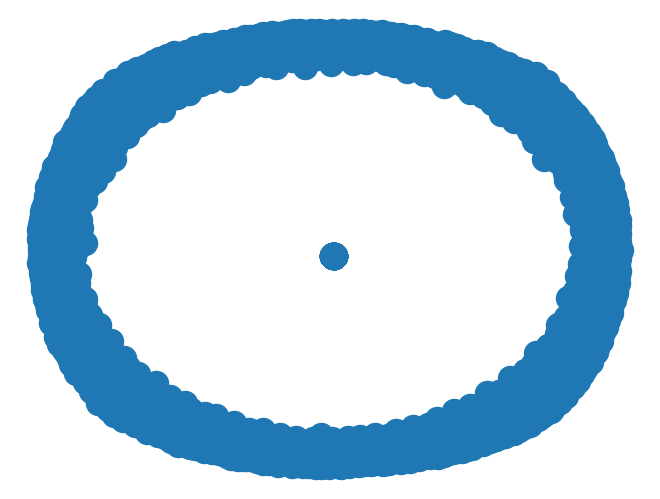

In [23]:
nx.draw(G)

#WORD2VEC

In [24]:
#                random walks
# ===========================================================================

# path_lengh - соответствует параметру t
def get_randomwalk(G, node, path_length):
    
    random_walk = [node]
    #print ('начинаем с узла', random_walk)
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        # print('соседи', temp)
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [29]:
#      the number of random walks per node of the graph (gamma)
# ===========================================================================

all_nodes = list(G.nodes())
gamma = 80
t = 80
random_walks = []
for n in tqdm(all_nodes):
    for i in range(gamma):
        random_walks.append(get_randomwalk(G, n, t))
        
# полученное число случайных блужданий
len(random_walks)

100%|██████████| 2831/2831 [00:55<00:00, 51.01it/s]


226480

In [31]:
type(random_walks)

list

In [30]:
#                training
# ===========================================================================

warnings.filterwarnings('ignore')

model = Word2Vec(window = 10, sg = 1, hs = 0, batch_words=3000,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.005,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=3, report_delay=1)

(5834786, 6367440)

In [37]:
X = model[model.wv.get_vector(word)] #эмбединги

AttributeError: ignored

In [ ]:
#                embendings
# ===========================================================================

X = model[model.wv.vocab] #эмбединги
model.wv.vocab # сами ключи - номера узлов

In [ ]:
#                demension reduction
# ===========================================================================

#from random import randint
#from sklearn.manifold import TSNE

# ----- Параметры функций -----------------------
#labels - метки кластера
#node_list- идентификаторы узлов графа список
#X_embedding - признаковое описание каждого объекта (матрица) 
#annotate - выводить ли подписи названий узлов на график
#annotate_labes  - словарь с названиями узлов



def plot_nodes(node_list, X_embedding, labels = [], annotate = False, annotate_labes = {} ):
    X = X_embedding

    #цвет, при отсутствии меток кластера
    colors = ['#6495ED' for i in node_list]
    map={}
    #если метки кластера в наличии, то случайно выбираем цвета
    if len(labels) != 0:
       for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
       colors = [map[i] for i in labels]
    
    # уменьшаем размерность до 2х
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    

    
    plt.figure(figsize=(6,3))
    # create a scatter plot of the projection

    plt.scatter(result[:, 0], result[:, 1],  c=colors)
    for i, node in enumerate(node_list):
         if (annotate_labes[node] !='-' and annotate ==True):
          plt.annotate(annotate_labes[node], xy=(result[i, 0], result[i, 1]))
    
    plt.show()



###------------------------
def plot_TSNE_nodes(node_list, X_embedding, labels = [], annotate = False, annotate_labes = {}):

    colors = ['#6495ED' for i in node_list]
    map={}
    if len(labels) != 0:
      for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
      colors = [map[i] for i in labels]
    X = X_embedding

    tsne = TSNE(n_components=2, verbose=0, perplexity=7)
    tsne_results = tsne.fit_transform(X)

    plt.figure(figsize=(9,6))
    # create a scatter plot of the projection
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = colors)
    for i, node in enumerate(node_list):
        if (annotate_labes[node] !='-' and annotate ==True):
          plt.annotate(annotate_labes[node], xy=(tsne_results[i, 0], tsne_results[i, 1]))
    plt.show()

#### ОБА ГРАФИКА ДЛЯ СРАВНЕНИЯ ---------------------------
def plot_TSNE_PCA_nodes(node_list, X_embedding, labels = [], annotate = False, annotate_labes = {}):

    colors = ['#6495ED' for i in node_list]
    map={}
    if len(labels) != 0:
      for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
      colors = [map[i] for i in labels]
    X = X_embedding
    tsne = TSNE(n_components=2, verbose=0, perplexity=7)
    #perpexity	Степень хаоса, которая указывает, сколько соседних точек учитывается при оптимизации t-SNE,
    # по умолчанию 30, а рекомендуемое значение от 5 до 50
    tsne_results = tsne.fit_transform(X)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(pca_result[:, 0], pca_result[:, 1],  c=colors)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne_results[:, 0], tsne_results[:, 1], c = colors)
    ax[1].set_title('TSNE Cluster Plot') 
    plt.show()

##############################################################################################
#метки узлов в словаре для графиков

list_labels ={}
for node in G.nodes:
  list_labels[node]=G.nodes[node]['label']

#list_labels  

list_labels ={}
for node in G.nodes:
  list_labels[node]=G.nodes[node]['label']

list_labels

#DEEP WALK

In [38]:
!pip install karateclub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.0 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=101986 sha256=79ee0153441b54278d3d01a7049e56a146d4e0be453aaa0ff1371317446016c0
  Stored in directory: /root/.cache/pip/wheels/62/bd/af/17e7ca6ba0ed144d22502780f5c0660a8e4985939dc6973a81
Successfully built karateclub
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Un

In [41]:
# идентификаторы узлов должны быть целыми для использования библиотека, а тут строки, поэтому делается конвертация
G1 = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')
G1.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [42]:
from karateclub import DeepWalk

# дип валк - эмбединг с рекомендованными параметрами
model = DeepWalk(walk_length=80, dimensions=100, window_size=10)
model.fit(G1)
embed = model.get_embedding()
print('векторное представление узлов', embed) # вывод векторов
print('весь список узлов', list(G1.nodes)) #сами узлы


векторное представление узлов [[ 1.1171379  -0.52565354 -0.00515135 ...  0.09554706  0.16037263
   0.48956966]
 [ 0.9350058  -0.52279     0.0119933  ...  0.14323346  0.18394896
   0.39692512]
 [ 0.9814703  -0.5254752  -0.07871575 ...  0.16284049  0.08093791
   0.4010816 ]
 ...
 [ 1.2018569  -0.6140986  -0.04593981 ...  0.1689908   0.18638806
   0.44421184]
 [ 1.0019348  -0.5011013  -0.03605917 ...  0.14246556  0.10221928
   0.43214142]
 [ 1.0018253  -0.5489098  -0.06339131 ...  0.18112022  0.14415446
   0.42850783]]
весь список узлов [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,

In [48]:
type(embed)

numpy.ndarray

#ЭМБЕДДИНГ - EMBED

In [63]:
embed

array([[ 1.1171379 , -0.52565354, -0.00515135, ...,  0.09554706,
         0.16037263,  0.48956966],
       [ 0.9350058 , -0.52279   ,  0.0119933 , ...,  0.14323346,
         0.18394896,  0.39692512],
       [ 0.9814703 , -0.5254752 , -0.07871575, ...,  0.16284049,
         0.08093791,  0.4010816 ],
       ...,
       [ 1.2018569 , -0.6140986 , -0.04593981, ...,  0.1689908 ,
         0.18638806,  0.44421184],
       [ 1.0019348 , -0.5011013 , -0.03605917, ...,  0.14246556,
         0.10221928,  0.43214142],
       [ 1.0018253 , -0.5489098 , -0.06339131, ...,  0.18112022,
         0.14415446,  0.42850783]], dtype=float32)

In [59]:
len(embed)

2831

In [43]:
from scipy.spatial.distance import cdist
import numpy as np

M = 1 - cdist(embed, embed, metric='cosine')
print (M.shape)
# это матрица схожести.
# Теперь для того, чтобы найти 10 наиболее похожих на 1ый узел нужно найти 10 
# самых больших значений. Чем ближе к 1 тем больше схожесть, чем меньше, тем меньше.

# выбираем 1ую строку - это схожесть всех узлов с 1ым.
print (M[0,:])

# смотрим 4 самых похожих
temp = np.argpartition(-M[0,:], 10)
result_args = temp[:10]
print (result_args)

(2831, 2831)
[1.         0.99286158 0.98920745 ... 0.99466874 0.99382702 0.99270402]
[   0 2770 2738 2737 2676 2659 2723 2616 2718 2822]


In [58]:
len(M)

2831

In [56]:
len(result_args)

10

In [52]:
# матрица схожести 
M

array([[1.        , 0.99286158, 0.98920745, ..., 0.99466874, 0.99382702,
        0.99270402],
       [0.99286158, 1.        , 0.99234992, ..., 0.99475939, 0.99561385,
        0.99562058],
       [0.98920745, 0.99234992, 1.        , ..., 0.99645649, 0.99631177,
        0.99771872],
       ...,
       [0.99466874, 0.99475939, 0.99645649, ..., 1.        , 0.9959029 ,
        0.99663054],
       [0.99382702, 0.99561385, 0.99631177, ..., 0.9959029 , 1.        ,
        0.99692507],
       [0.99270402, 0.99562058, 0.99771872, ..., 0.99663054, 0.99692507,
        1.        ]])

In [44]:
#                   visualisation functions
# ============================================================================

from random import randint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#labels - метки кластера
#word_list - идентификаторы узлов графа
#annotate - выводить ли подписи названий узлов на график
def plot_PCA_nodes(G1, X_scaled, nodes_list,  labels = [],annotate = False , random_st=10):
    
    X = X_scaled
    colors = ['#6495ED' for i in nodes_list]
    map={}
    if len(labels) != 0:
       for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
       colors = [map[i] for i in labels]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1],  c=colors)
    for i, node in enumerate(nodes_list):
        if (G1.nodes[ node ]['label'] !='-' and annotate==True):
           plt.annotate(G1.nodes[ node ]['label'], xy=(result[i, 0], result[i, 1]))
    
    plt.show()
   


    
    

def plot_TSNE_nodes(G1, X_scaled, nodes_list, labels = [], annotate = False, random_st=10):

    colors = ['#6495ED' for i in nodes_list]
    map={}
    if len(labels) != 0:
      for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
      colors = [map[i] for i in labels]

    X = X_scaled


    tsne = TSNE(n_components=2, verbose=0, perplexity=7, n_iter=150,  init='random', random_state=random_st)
    tsne_results = tsne.fit_transform(X)
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = colors)
    for i, node in enumerate(nodes_list):
        if (G1.nodes[node]['label'] !='-' and annotate ==True):
          plt.annotate(G1.nodes[node]['label'], xy=(tsne_results[i, 0], tsne_results[i, 1]))
    plt.show()


def plot_TSNE_PCA_nodes(G1, x_scaled, nodes_list, labels = [], annotate = False, random_st=10):

    colors = ['#6495ED' for i in nodes_list]
    map={}
    if len(labels) != 0:
      for i in set(labels):
         map[i]='#%06X' % randint(0, 0xFFFFFF)
      colors = [map[i] for i in labels]


    X = X_scaled

    tsne = TSNE(n_components=2, verbose=0, perplexity=7,   learning_rate="auto",  init='pca', random_state=random_st)
    tsne_results = tsne.fit_transform(X)

    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(X)
    
    f, ax = plt.subplots(1, 2, figsize=(40, 20))
    ax[0].scatter(pca_results[:, 0], pca_results[:, 1],  c=colors)
    ax[0].set_title('PCA Cluster Plot')
    
    
  

    ax[1].scatter(tsne_results[:, 0], tsne_results[:, 1], c = colors)
    ax[1].set_title('TSNE Cluster Plot')

    for i, node in enumerate(nodes_list):
        if (G1.nodes[node]['label'] !='-' and annotate ==True):
          ax[0].annotate(G1.nodes[node]['label'], xy=(pca_results[i, 0], pca_results[i, 1]))
          ax[1].annotate(G1.nodes[node]['label'], xy=(tsne_results[i, 0], tsne_results[i, 1]))
    plt.show()

KeyError: ignored

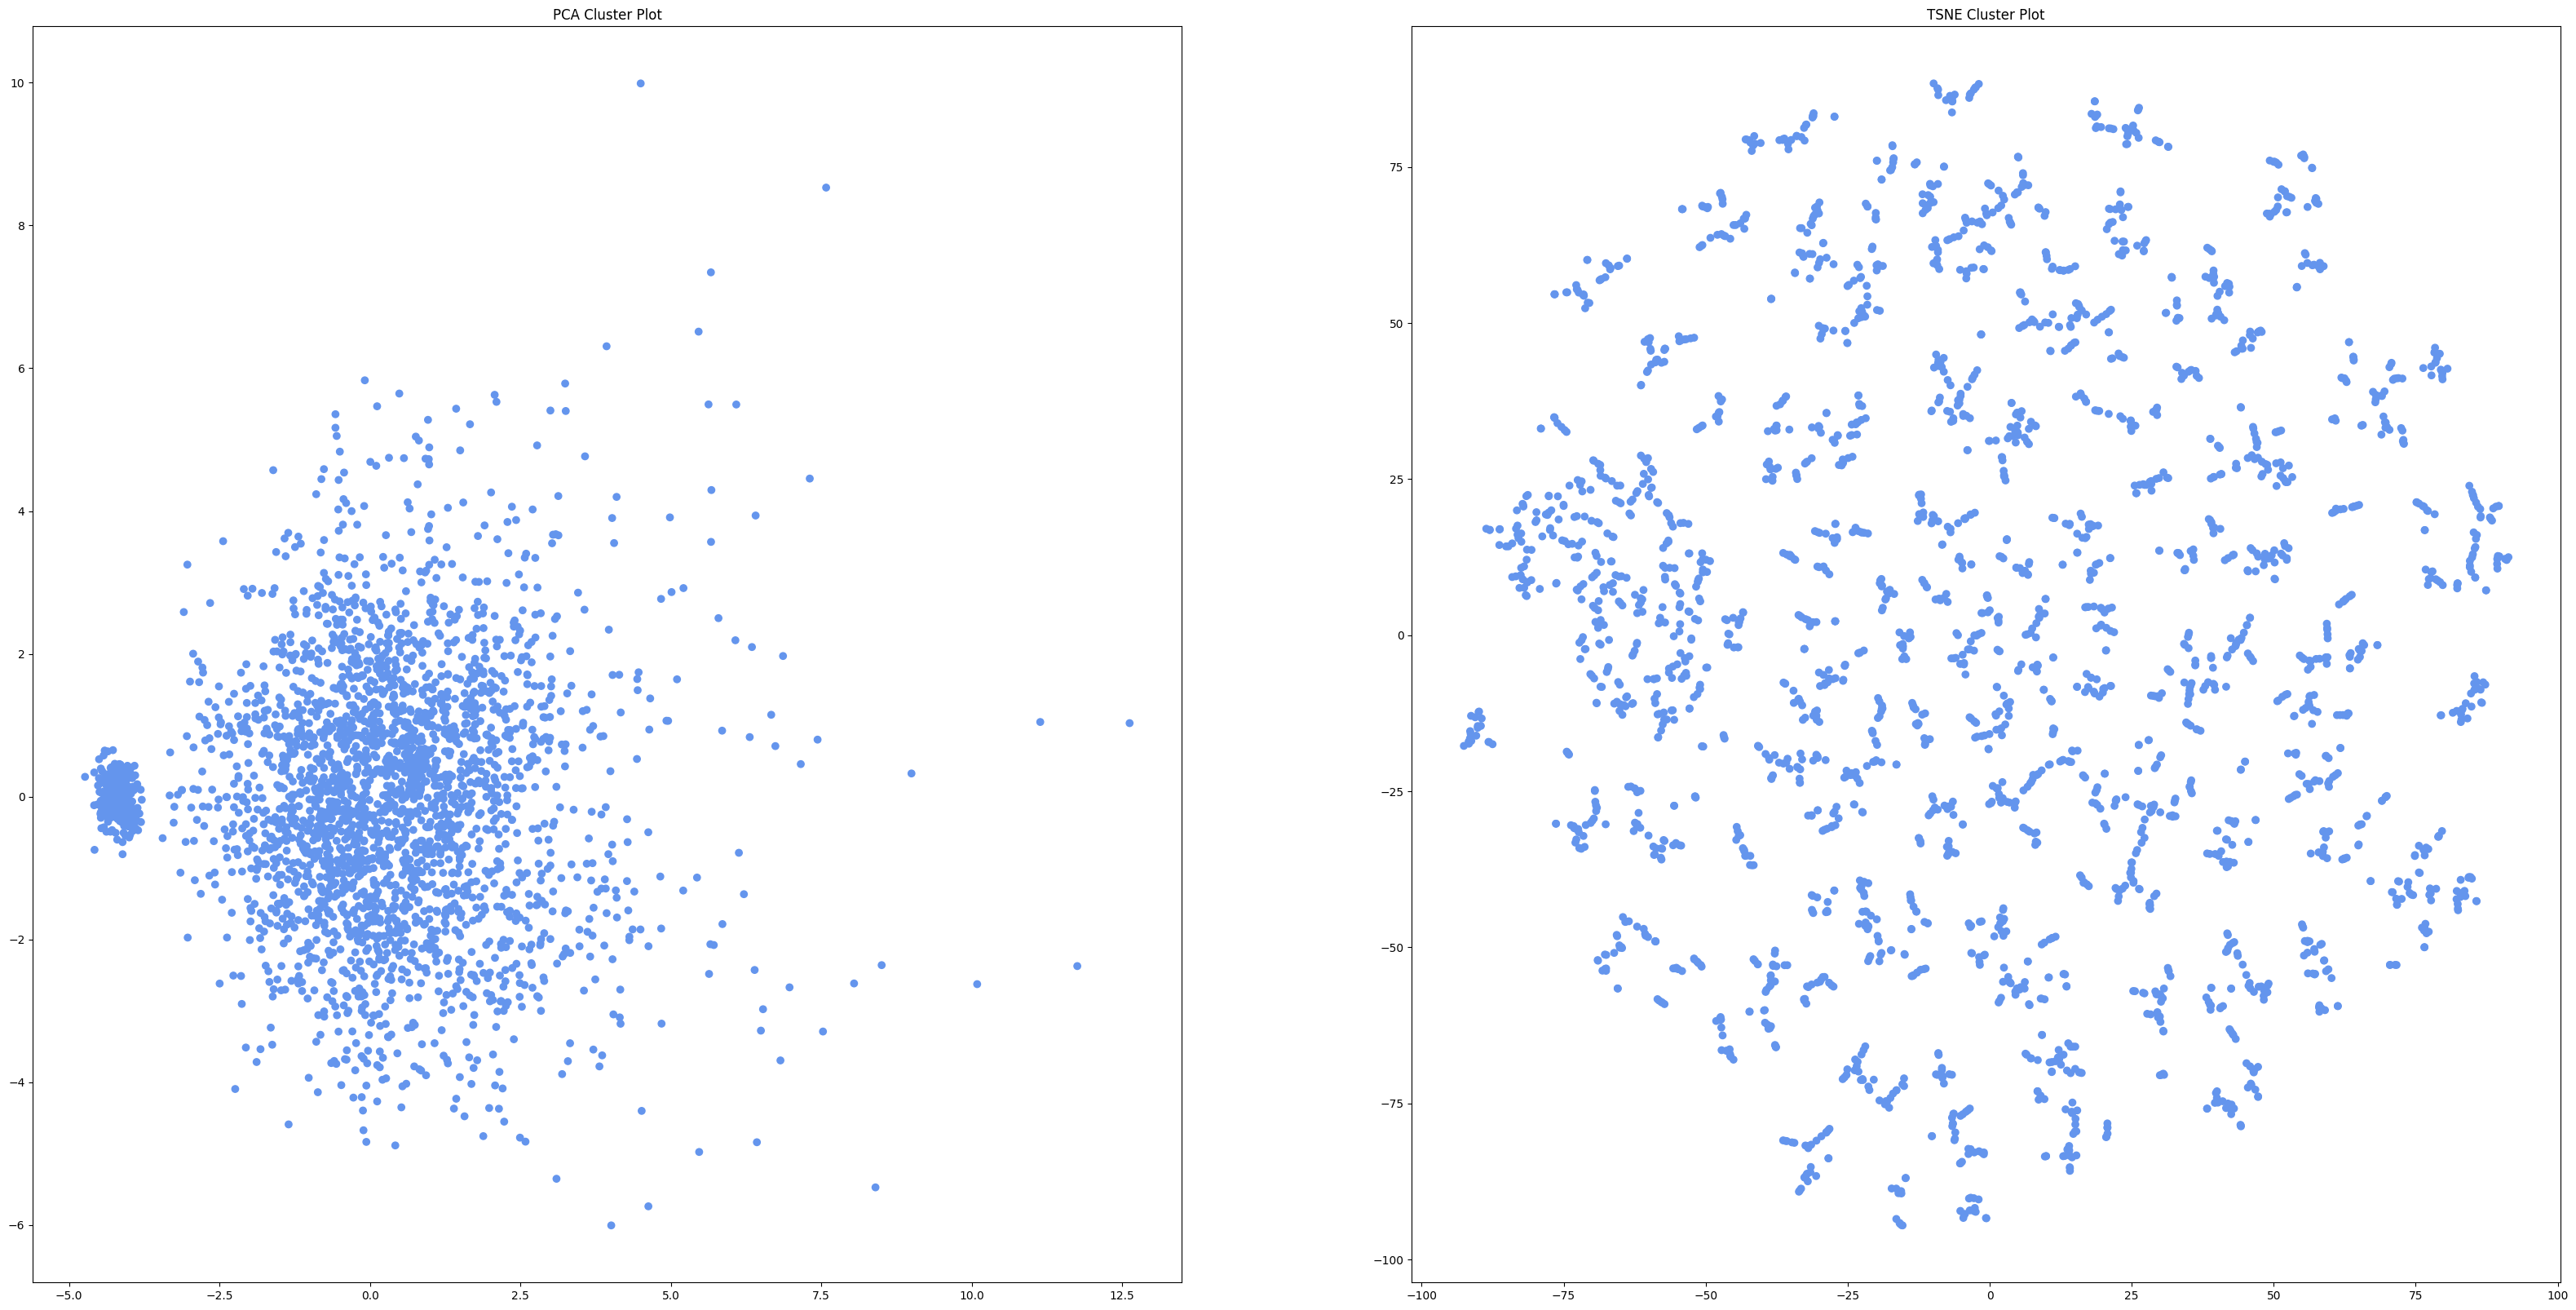

In [49]:
#                  plot
# ============================================================================

X = embed

X_scaled = X

# plot_PCA_nodes(G1, X_scaled, list(G1.nodes), labels = [], annotate = False, random_st=15)

plot_TSNE_PCA_nodes(G1,X_scaled, list(G1.nodes), labels = [], annotate = False, random_st=15)

#SUBMISSION

In [72]:
test1

,ego_id,u,v,t,x1,x2,x3
0,8,20,19,185.7,3.839089e-04,0.0,0.0
1,8,131,125,161.4,4.034464e-01,0.0,0.0
2,8,73,56,127.0,8.554643e-05,0.0,0.0
3,8,0,4,594.5,2.886418e-01,0.0,0.0
4,8,63,73,127.0,4.281692e-07,0.0,0.0
...,...,...,...,...,...,...,...
5002679,214748365067,175,77,10.9,1.169437e+00,0.0,0.0
5002680,214748365067,68,175,248.3,7.352047e-01,0.0,0.0
5002681,214748365067,25,0,65.3,2.035224e-01,0.0,0.0
5002682,214748365067,85,246,35.6,2.781017e-02,0.0,0.0


In [73]:
x = test1.drop(columns=['x1'])
x

,ego_id,u,v,t,x2,x3
0,8,20,19,185.7,0.0,0.0
1,8,131,125,161.4,0.0,0.0
2,8,73,56,127.0,0.0,0.0
3,8,0,4,594.5,0.0,0.0
4,8,63,73,127.0,0.0,0.0
...,...,...,...,...,...,...
5002679,214748365067,175,77,10.9,0.0,0.0
5002680,214748365067,68,175,248.3,0.0,0.0
5002681,214748365067,25,0,65.3,0.0,0.0
5002682,214748365067,85,246,35.6,0.0,0.0


In [1]:
y = test1['x1']
y = pd.DataFrame(y, columns=['x1'])

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [61]:
submission = pd.read_csv('/content/submission.csv')
submission

,ego_id,u,v,x1
0,8,0,93,0.000000
1,8,0,143,0.000000
2,8,0,151,1.606742
3,8,1,24,0.026496
4,8,5,4,0.159857
...,...,...,...,...
810971,1709396984676,73,23,1.562170
810972,1709396984676,74,68,0.454210
810973,1709396984676,77,28,0.078504
810974,1709396984676,79,38,0.981812


In [ ]:
sub_ego = 

In [69]:
Y = pd.DataFrame(x1, columns=['x1'])
Y

,x1
0,0.000000
1,0.000000
2,1.606742
3,0.026496
4,0.159857
...,...
810971,1.562170
810972,0.454210
810973,0.078504
810974,0.981812
